In [14]:
import xarray as xr
import geopandas as gpd
import numpy as np
from scipy.spatial import KDTree
from shapely.geometry import LineString, Point
from pyproj import Transformer
import matplotlib.pyplot as plt

In [2]:
from pathlib import Path
input_folder = Path('boundary_conditions')
output_folder = Path('boundary_conditions/preprocessed_WL')

1. Loading WL Boundary Polyline (Same as Wave Maker in IWS Scenario)

In [3]:
epsg = 32736
bc_file_path = input_folder / 'gis' / 'wavemaker.gpkg'
bc_df = gpd.read_file(bc_file_path).to_crs(epsg=epsg)

2. Make the BC Line to Have At Least One Point for Every 1000 m (Same as GCC) and Then Project to WGS84

In [ ]:
# Function to approximate points along a polyline
transformer_to_wgs84 = Transformer.from_crs("EPSG:32736", "EPSG:4326", always_xy=True)

# Function to approximate points along a polyline
def approximate_points(line, distance=1000):
    length = line.length
    points = [line.interpolate(d) for d in range(0, int(length) + distance, distance)]
    return [(point.y, point.x) for point in points]

bc_coords = bc_df.geometry.apply(
    lambda geom: approximate_points(geom) if isinstance(geom, LineString) else None
)
bc_coords = [coords for coords in bc_coords if coords is not None]
bc_coords_flat = [pt for sublist in bc_coords for pt in sublist]

# Convert bc_coords_flat from UTM to WGS84
bc_coords_flat = [transformer_to_wgs84.transform(x, y) for y, x in bc_coords_flat]

print(bc_coords_flat)

3. Import Nearest ERA5 Wave Value

In [6]:
era5_file_path = input_folder / 'wave' / 'era5_wave_preprocessed.nc'
era5_ds = xr.open_dataset(era5_file_path)

era5_ds.load()

<xarray.Dataset> Size: 30kB
Dimensions:  (time: 744, index: 1)
Coordinates:
    number   int64 8B 0
  * time     (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
    y        (index) float64 8B -20.2
    x        (index) float64 8B 35.2
    expver   (time) <U4 12kB '0001' '0001' '0001' ... '0001' '0001' '0001'
Dimensions without coordinates: index
Data variables:
    wd       (time, index) float32 3kB 109.4 110.6 111.7 ... 131.5 131.4 131.4
    tp       (time, index) float32 3kB 5.437 5.547 5.627 ... 5.351 5.37 5.389
    hs       (time, index) float32 3kB 0.6595 0.6376 0.6181 ... 0.6759 0.6815
    ds       (time, index) float32 3kB 30.0 30.0 30.0 30.0 ... 30.0 30.0 30.0
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-24T15:14 GRIB to CDM+CF via cfgrib-0.9.1...
    crs:                     EPSG:4326

In [7]:
# Extract the "swh" variable (Significant Wave Height) from the NetCDF dataset
swh = era5_ds['hs']
lats = era5_ds['y'].values 
lons = era5_ds['x'].values 
times = era5_ds['time'].values

# Function to find the nearest index for a given value in an array
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

swh_values = []
for lat, lon in bc_coords_flat:
    lat_idx = find_nearest(lats, lat)
    lon_idx = find_nearest(lons, lon)
    
    if 'y' in swh.dims and 'x' in swh.dims:
        swh_at_point = swh[:, lat_idx, lon_idx]
    else:
        swh_at_point = swh[:, 0]
    
    swh_values.append(swh_at_point.values)

swh_values = np.stack(swh_values)

swh_ds = xr.Dataset(
    {
        "swh": (("location", "time"), swh_values)
    },
    coords={
        "latitude": ("location", [pt[0] for pt in bc_coords_flat]),
        "longitude": ("location", [pt[1] for pt in bc_coords_flat]),
        "time": times,
        "location": range(len(bc_coords_flat)),
    }
)

In [8]:
swh_ds

<xarray.Dataset> Size: 339kB
Dimensions:    (location: 111, time: 744)
Coordinates:
    latitude   (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
    longitude  (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
  * time       (time) datetime64[ns] 6kB 2019-03-01 ... 2019-03-31T23:00:00
  * location   (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    swh        (location, time) float32 330kB 0.6595 0.6376 ... 0.6759 0.6815

4. Import Nearest DFM WL

In [9]:
dfm_file_path = r'C:\Intern\SFINCS_Sofala\boundary_conditions\DFM_output\mozambique_spw_Idai_areaBeira_500m_gebco2023_map.nc'
dfm_ds = xr.open_dataset(dfm_file_path)

# Extract the water level (mesh2d_s1), mesh2d_face_y (latitude), mesh2d_face_x (longitude), and time from the DFM dataset
water_level = dfm_ds['mesh2d_s1'] 
lats = dfm_ds['mesh2d_face_y'].values
lons = dfm_ds['mesh2d_face_x'].values 
times = dfm_ds['time'].values  

coordinates = np.column_stack([lons, lats])
tree = KDTree(coordinates)


water_level_values = []
latitudes = []
longitudes = []
for lon, lat in bc_coords_flat:
    dist, idx = tree.query([lon, lat])
    water_level_at_point = water_level[:, idx] 

    water_level_values.append(water_level_at_point.values)
    latitudes.append(lat)
    longitudes.append(lon)

water_level_values = np.array(water_level_values)

wl_ds = xr.Dataset(
    {
        "water_level": (("location", "time"), water_level_values)
    },
    coords={
        "latitude": ("location", latitudes),
        "longtitude": ("location", longitudes),
        "time": times,
        "location": range(len(bc_coords_flat)),
    }
)

In [10]:
wl_ds

<xarray.Dataset> Size: 154kB
Dimensions:      (location: 111, time: 169)
Coordinates:
    latitude     (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
    longtitude   (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
  * time         (time) datetime64[ns] 1kB 2019-03-09 ... 2019-03-16
  * location     (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
Data variables:
    water_level  (location, time) float64 150kB 0.0 -0.003464 ... 0.2766 0.01589

5. Combine Both SWH and WL to Produce 0.2 Hs

In [11]:
# Subset the SWH data (ERA5) to match the time range of the DFM water level data
swh_ds_subset = swh_ds.sel(time=slice(wl_ds['time'].min(), wl_ds['time'].max()))

# Combine the water level and SWH data for each point location
combined_wl = wl_ds['water_level'] + 0.2 * swh_ds_subset['swh']

waterlevel_data = combined_wl.transpose("time", "location").values
time_values = swh_ds_subset['time'].values
lat_values = wl_ds['latitude'].values
long_values = wl_ds['longtitude'].values
point_index = np.arange(len(lat_values))

combined_ds = xr.Dataset(
    {
        "waterlevel": (("time", "location"), waterlevel_data)  
    },
    coords={
        "time": time_values,                   
        "location": point_index,                   
        "lat": ("location", lat_values),           
        "long": ("location", long_values)           
    }
)

# Save the result as a new NetCDF file with the desired structure
combined_output_path = output_folder / '0.2hs_WL.nc'
combined_ds.to_netcdf(combined_output_path)

print(f"Combined WL and SWH data saved to {combined_output_path}.")

Combined WL and SWH data saved to boundary_conditions\preprocessed_WL\0.2hs_WL.nc.


In [12]:
combined_ds

<xarray.Dataset> Size: 154kB
Dimensions:     (time: 169, location: 111)
Coordinates:
  * time        (time) datetime64[ns] 1kB 2019-03-09 ... 2019-03-16
  * location    (location) int32 444B 0 1 2 3 4 5 6 ... 105 106 107 108 109 110
    lat         (location) float64 888B -20.36 -20.35 -20.34 ... -19.54 -19.54
    long        (location) float64 888B 34.82 34.83 34.83 ... 35.34 35.35 35.36
Data variables:
    waterlevel  (time, location) float64 150kB 0.1985 0.1985 ... 0.369 0.3681

See how it compares to DFM WL

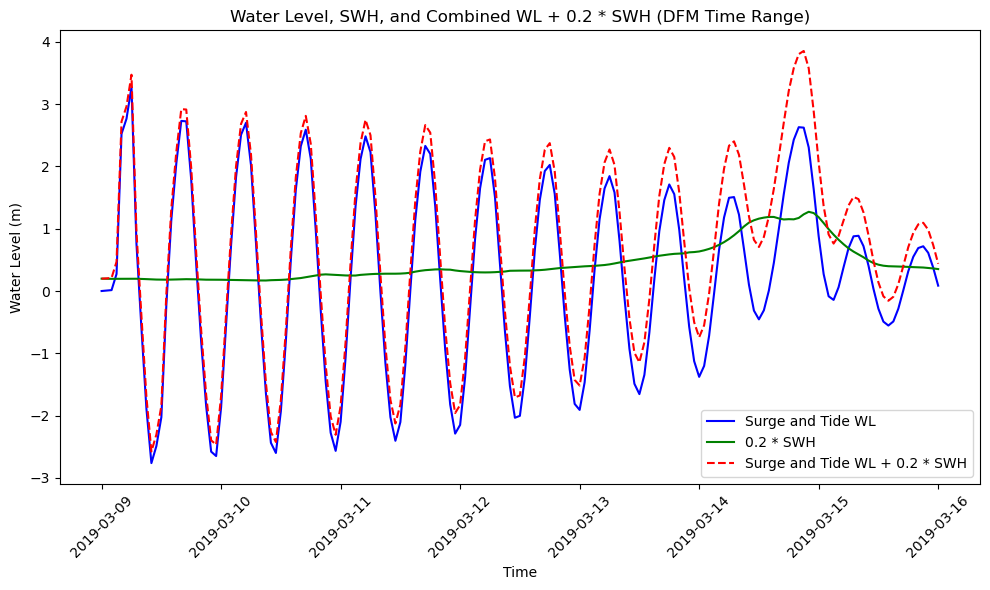

In [15]:
location = 50  # Adjust the location index if needed

dfm_time = wl_ds['time']
start_time = dfm_time.min().values
end_time = dfm_time.max().values

combined_wl = combined_ds['waterlevel'].isel(location=location).sel(time=slice(start_time, end_time))
swh = swh_ds['swh'].isel(location=location).sel(time=slice(start_time, end_time))
original_wl = wl_ds['water_level'].isel(location=location).sel(time=slice(start_time, end_time))
time = original_wl['time']

plt.figure(figsize=(10, 6))
plt.plot(time, original_wl, label='Surge and Tide WL', color='blue')
plt.plot(time, 0.2 * swh, label='0.2 * SWH', color='green')
plt.plot(time, combined_wl, label='Surge and Tide WL + 0.2 * SWH', color='red', linestyle='--')
plt.title('Water Level, SWH, and Combined WL + 0.2 * SWH (DFM Time Range)')
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

plt.legend()

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()